<div align="left" style="font-weight: bold; font-family: Computer Modern; font-size: 20px; text-align: left; line-height: 1.5;">
    Universidade Federal da Bahia (UFBA)
    <br>
    Departamento de Engenharia Elétrica e da Computação (DEEC)
    <br>
    Disciplina: ENGG64 - Visão Computacional
    <br>
    Docente: André Gustavo Scolari Conceição
    <br>
    Discente: Gabriel Correia e Marcio Barros
</div>


---

PROJETO - ESTIMAÇÃO ROBÔ MÓVEL

In [51]:
### Carregando as Bibliotecas a serem utilizadas em cada etapa do programa

import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import FancyArrowPatch

PARTE 1 - Plotando o Video Completo do Movimento Geral do Robô

Resultados Obtidos no Programa: 


C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\3355186497.py:69: RuntimeWarning: divide by zero encountered in divide
  r = R / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\3355186497.py:70: RuntimeWarning: divide by zero encountered in divide
  g = G / Y


KeyboardInterrupt: 

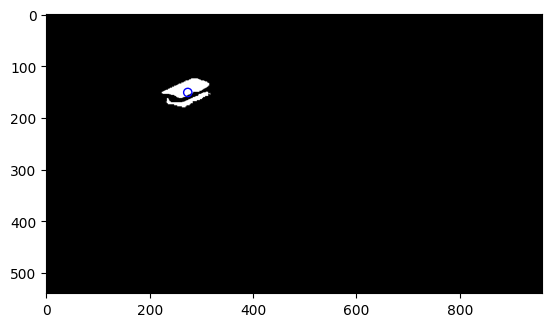

In [52]:
plt.close('all')
print('Resultados Obtidos no Programa: ')

# Carregando o arquivo de vídeo
husky = cv2.VideoCapture("video1_husky.mp4")

# Definindo S1
S1 = np.ones((3, 3), dtype=np.uint8)

def plot_moments(image):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    m00 = np.sum(image)
    #print("ÁREA =", m00)

    rows, cols = image.shape
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    uc = np.sum(X * image) / m00
    vc = np.sum(Y * image) / m00

    ax.scatter(uc, vc, c='none', edgecolors='b', marker='o', label='Centroide')
    #print('O centroide da imagem é:', [uc, vc])

    u20 = np.sum((X - uc)**2 * image) / m00
    u02 = np.sum((Y - vc)**2 * image) / m00
    u11 = np.sum((X - uc) * (Y - vc) * image) / m00
    J = np.array([[u20, u11], [u11, u02]])

    #print("\n---------------------------------------------")
    #print("Momentos centrais e matriz de inércia")
    #print(J)
    #print("---------------------------------------------")
    lmbda, x = np.linalg.eig(J)
    i = np.argmax(lmbda)
    v = x[:, i]
    angle = np.rad2deg(np.arctan2(v[1], v[0]))
    #print("DIREÇÃO =", angle, 'GRAUS')

    ellipse = plt.matplotlib.patches.Ellipse((uc, vc), width=np.sqrt(lmbda[0] * 5.991), height=np.sqrt(lmbda[1] * 5.991),
                                             angle=angle, edgecolor='c', linewidth=2, fill=False, label='Inércia')
    ax.add_patch(ellipse)

    ax.legend()
    plt.close(fig)  # Fechar a figura após obter os dados

    return fig

### -> Configuração do arquivo de vídeo de saída
video_writer = imageio.get_writer('husky1_with_ellipse1.mp4', fps=5)

# A cada frame do vídeo carregado, será realizada um conjunto de operações
i = 0
while husky.isOpened():
    ret, frame = husky.read()
    if not ret:
        break

    # Convertendo para escala de cinza
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Geramos aqui a cromaticidade do frame
    R = frame[:, :, 2]
    B = frame[:, :, 0]
    G = frame[:, :, 1]
    Y = R + B + G
    r = R / Y
    g = G / Y

    # Com r podemos aplicar o thresholding para demilitar a caixa
    # Limites para delimitar a parte vermelha do husky
    Frame_tresh = ((r >= 0.5) & (g <= 0.2)).astype(np.uint8) * 255

    # Removendo o ruído da imagem
    Frame_noise = cv2.erode(cv2.dilate(Frame_tresh, S1), S1)
    # Frame_noise = cv2.erode(cv2.dilate(Frame_noise, S2), S2)

    # Gerando os blobs da imagem
    _, Frame_blobs = cv2.connectedComponents(Frame_noise)
    Frame_blobs = Frame_blobs > 0

    ### -> Configurar o intervalo de plotagem dos quadros do video original
    numero_de_frames = 100

    if i % numero_de_frames == 0:
        fig = plot_moments(Frame_blobs)
        
        # Salvar o frame com a elipse no arquivo de vídeo
        canvas = FigureCanvas(fig)
        canvas.draw()
        img = np.array(canvas.renderer.buffer_rgba())
        video_writer.append_data(img)

    i = i + 1

husky.release()
video_writer.close()

plt.close('all')

PARTE 2 - Plotando o Video Completo do Movimento Geral do Robô com o Rastro formado

In [ ]:
plt.close('all')
print('Resultados Obtidos no Programa: ')

# Carregando o arquivo de vídeo
husky = cv2.VideoCapture("video1_husky.mp4")

# Definindo S1
S1 = np.ones((3, 3), dtype=np.uint8)

def plot_moments(image, centroid_history):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    m00 = np.sum(image)
    #print("ÁREA =", m00)

    rows, cols = image.shape
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    uc = np.sum(X * image) / m00
    vc = np.sum(Y * image) / m00

    centroid_history.append((uc, vc))  # Adiciona a posição atual à lista de histórico

    # Desenha a trajetória (rastro) do centróide
    if len(centroid_history) > 1:
        centroid_history_np = np.array(centroid_history)
        ax.plot(centroid_history_np[:, 0], centroid_history_np[:, 1], 'ro-', label='Trajetória')

    ax.scatter(uc, vc, c='none', edgecolors='b', marker='o', label='Centroide')
    #print('O centroide da imagem é:', [uc, vc])

    u20 = np.sum((X - uc)**2 * image) / m00
    u02 = np.sum((Y - vc)**2 * image) / m00
    u11 = np.sum((X - uc) * (Y - vc) * image) / m00
    J = np.array([[u20, u11], [u11, u02]])

    #print("\n---------------------------------------------")
    #print("Momentos centrais e matriz de inércia")
    #print(J)
    #print("---------------------------------------------")
    lmbda, x = np.linalg.eig(J)
    i = np.argmax(lmbda)
    v = x[:, i]
    angle = np.rad2deg(np.arctan2(v[1], v[0]))
    #print("DIREÇÃO =", angle, 'GRAUS')

    ellipse = plt.matplotlib.patches.Ellipse((uc, vc), width=np.sqrt(lmbda[0] * 5.991), height=np.sqrt(lmbda[1] * 5.991),
                                             angle=angle, edgecolor='c', linewidth=2, fill=False, label='Inércia')
    ax.add_patch(ellipse)

    ax.legend()
    plt.close(fig)  # Fechar a figura após obter os dados

    return fig

### -> Configuração do arquivo de vídeo de saída
video_writer = imageio.get_writer('husky1_with_ellipse_and_trace1.mp4', fps=5)

# Lista para armazenar o histórico de posições do centróide
centroid_history = []

# A cada frame do vídeo carregado, será realizada um conjunto de operações
i = 0
while husky.isOpened():
    ret, frame = husky.read()
    if not ret:
        break

    # Convertendo para escala de cinza
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Geramos aqui a cromaticidade do frame
    R = frame[:, :, 2]
    B = frame[:, :, 0]
    G = frame[:, :, 1]
    Y = R + B + G
    r = R / Y
    g = G / Y

    # Com r podemos aplicar o thresholding para demilitar a caixa
    # Limites para delimitar a parte vermelha do husky
    Frame_tresh = ((r >= 0.5) & (g <= 0.2)).astype(np.uint8) * 255

    # Removendo o ruído da imagem
    Frame_noise = cv2.erode(cv2.dilate(Frame_tresh, S1), S1)
    # Frame_noise = cv2.erode(cv2.dilate(Frame_noise, S2), S2)

    # Gerando os blobs da imagem
    _, Frame_blobs = cv2.connectedComponents(Frame_noise)
    Frame_blobs = Frame_blobs > 0

    ### -> Configurar o intervalo de plotagem dos quadros do video original
    numero_de_frames = 100

    if i % numero_de_frames == 0:
        fig = plot_moments(Frame_blobs, centroid_history)
        
        # Salvar o frame com a elipse e a trajetória no arquivo de vídeo
        canvas = FigureCanvas(fig)
        canvas.draw()
        img = np.array(canvas.renderer.buffer_rgba())
        video_writer.append_data(img)

    i = i + 1

    
husky.release()
video_writer.close()

plt.close('all')


Resultados Obtidos no Programa: 


C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\894584676.py:79: RuntimeWarning: divide by zero encountered in divide
  r = R / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\894584676.py:80: RuntimeWarning: divide by zero encountered in divide
  g = G / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\894584676.py:79: RuntimeWarning: invalid value encountered in divide
  r = R / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_8836\894584676.py:80: RuntimeWarning: invalid value encountered in divide
  g = G / Y


PARTE 3 - Plotando o Video Completo do Movimento Geral do Robô com o Rastro formado no Video Original

C:\Users\gcorr\AppData\Local\Temp\ipykernel_14040\169740988.py:38: RuntimeWarning: divide by zero encountered in divide
  r = R / Y
C:\Users\gcorr\AppData\Local\Temp\ipykernel_14040\169740988.py:39: RuntimeWarning: divide by zero encountered in divide
  g = G / Y
C:\Users\gcorr\AppData\Local\Temp\ipykernel_14040\169740988.py:38: RuntimeWarning: invalid value encountered in divide
  r = R / Y
C:\Users\gcorr\AppData\Local\Temp\ipykernel_14040\169740988.py:39: RuntimeWarning: invalid value encountered in divide
  g = G / Y


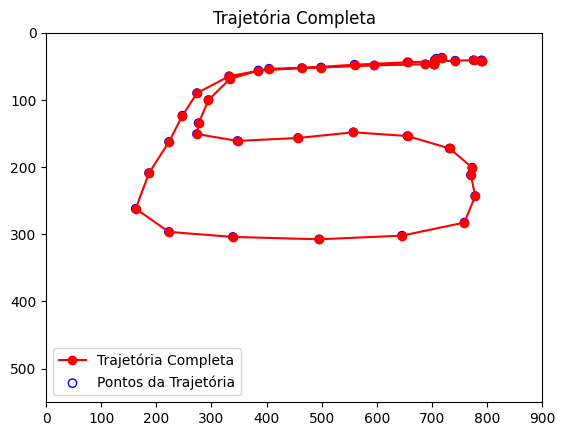

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio
import sys

plt.close('all')
print('Resultados Obtidos no Programa: ')

# Carregando o arquivo de vídeo
husky = cv2.VideoCapture("video1_husky.mp4")

# Definindo a quantidade de FPS do vídeo e intervalo entre os frames a serem amostrados:
fps = 25
numframes = 50

# Redirecionar a saída padrão para um arquivo de texto
sys.stdout = open('husky_informations.txt', 'w')

# Definindo S1
S1 = np.ones((3, 3), dtype=np.uint8)

def plot_moments(frame, centroid_history):
    fig, ax = plt.subplots()

    # Mostrar o frame original
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Convertendo para escala de cinza
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Geramos aqui a cromaticidade do frame
    R = frame[:, :, 2]
    B = frame[:, :, 0]
    G = frame[:, :, 1]
    Y = R + B + G
    r = R / Y
    g = G / Y

    # Com r podemos aplicar o thresholding para demilitar a caixa
    # Limites para delimitar a parte vermelha do husky
    Frame_tresh = ((r >= 0.5) & (g <= 0.2)).astype(np.uint8) * 255

    # Removendo o ruído da imagem
    Frame_noise = cv2.erode(cv2.dilate(Frame_tresh, S1), S1)
    # Frame_noise = cv2.erode(cv2.dilate(Frame_noise, S2), S2)

    # Gerando os blobs da imagem
    _, Frame_blobs = cv2.connectedComponents(Frame_noise)
    Frame_blobs = Frame_blobs > 0

    m00 = np.sum(Frame_blobs)
    rows, cols = Frame_blobs.shape
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    uc = np.sum(X * Frame_blobs) / m00
    vc = np.sum(Y * Frame_blobs) / m00

    centroid_history.append((uc, vc))  # Adiciona a posição atual à lista de histórico

    # Desenha a trajetória (rastro) do centróide
    if len(centroid_history) > 1:
        centroid_history_np = np.array(centroid_history)
        ax.plot(centroid_history_np[:, 0], centroid_history_np[:, 1], 'ro-', label='Trajetória')

    ax.scatter(uc, vc, c='none', edgecolors='b', marker='o', label='Centroide')
    print("\n------------------- Husky Information ----------------------")
    print('Centroide da Imagem:', [uc, vc])

    u20 = np.sum((X - uc)**2 * Frame_blobs) / m00
    u02 = np.sum((Y - vc)**2 * Frame_blobs) / m00
    u11 = np.sum((X - uc) * (Y - vc) * Frame_blobs) / m00
    J = np.array([[u20, u11], [u11, u02]])
    print("Momentos Centrais e Matriz de Inércia:")
    print(J)

    lmbda, x = np.linalg.eig(J)
    i = np.argmax(lmbda)
    v = x[:, i]
    angle = np.rad2deg(np.arctan2(v[1], v[0]))
    print("Direção:", angle, '[graus]')
    print("------------------------------------------------------------")

    ellipse = plt.matplotlib.patches.Ellipse((uc, vc), width=np.sqrt(lmbda[0] * 5.991), height=np.sqrt(lmbda[1] * 5.991),
                                             angle=angle, edgecolor='c', linewidth=2, fill=False, label='Inércia')
    ax.add_patch(ellipse)

    ax.legend()
    plt.close(fig)  # Fechar a figura após obter os dados

    return fig

### -> Configuração do arquivo de vídeo de saída
video_writer = imageio.get_writer('husky1_original_with_ellipse_and_trace.mp4', fps=fps)

# Lista para armazenar o histórico de posições do centróide
centroid_history = []

# Variáveis para calcular a distância total percorrida
total_distance = 0

# A cada frame do vídeo carregado, será realizada um conjunto de operações
i = 0
while husky.isOpened():
    ret, frame = husky.read()
    if not ret:
        break

    ### -> Configurar o intervalo de plotagem dos quadros do video original
    numero_de_frames = numframes

    if i % numero_de_frames == 0:
        fig = plot_moments(frame, centroid_history)

        # Calcular a distância percorrida no último intervalo
        if len(centroid_history) > 1:
            delta_x = centroid_history[-1][0] - centroid_history[-2][0]
            delta_y = centroid_history[-1][1] - centroid_history[-2][1]
            distance = np.sqrt(delta_x**2 + delta_y**2)
            total_distance += distance

        # Salvar o frame com a elipse e a trajetória no arquivo de vídeo
        canvas = FigureCanvas(fig)
        canvas.draw()
        img = np.array(canvas.renderer.buffer_rgba())
        video_writer.append_data(img)

    i += 1

# Calcular a velocidade média
tempo_total = i / fps
velocidade_media = total_distance / tempo_total

# Exibir e salvar a velocidade média, tempo e distância total
print("\n-------------------- Husky Parameters -----------------------")
print(f"Taxa de Quadro do Video: {fps} frames por segundo")
print(f"Intervalo de Amostragem a cada: {numframes} frames")
print(f"Velocidade Média do Husky: {velocidade_media} pixels por segundo")
print(f"Distância Total Percorrida pelo Husky: {total_distance} pixels")
print(f"Tempo Total Percorrido pelo Husky: {tempo_total} segundo")
print("--------------------------------------------------------------")

husky.release()
video_writer.close()

# Restaurar a saída padrão após a execução do programa
sys.stdout = sys.__stdout__

### Plotagem do Gráfico da Trajetória Completa realizada pelo Robô
# Plotar a trajetória completa após o loop do vídeo
trajectory_fig, trajectory_ax = plt.subplots()
centroid_history_np = np.array(centroid_history)

# Inverter o eixo Y e definir limites
trajectory_ax.set_xlim(0, 900)
trajectory_ax.set_ylim(0, 550)
trajectory_ax.invert_yaxis()

# Configurando a plotagem dos eixos, plotando e salvando o Gráfico da Trajetória do Husky
trajectory_ax.plot(centroid_history_np[:, 0], centroid_history_np[:, 1], 'ro-', label='Trajetória Completa')
trajectory_ax.scatter(centroid_history_np[:, 0], centroid_history_np[:, 1], c='none', edgecolors='b', marker='o', label='Pontos da Trajetória')
trajectory_ax.legend()
plt.title('Trajetória Completa')
plt.savefig('Husky_graphic_trajectory.png')
plt.show()

plt.close('all')


PARTE FINAL - PROJETO COMPLETO COM VIDEO ORIGINAL TENDO CENTROIDE, RASTRO, VETOR E VELOC. INSTANTÂNEA COM GRÁFICOS DE POSIÇÃO E ÂNGULO

C:\Users\GCorr\AppData\Local\Temp\ipykernel_17368\3725484864.py:41: RuntimeWarning: divide by zero encountered in divide
  r = R / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_17368\3725484864.py:42: RuntimeWarning: divide by zero encountered in divide
  g = G / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_17368\3725484864.py:41: RuntimeWarning: invalid value encountered in divide
  r = R / Y
C:\Users\GCorr\AppData\Local\Temp\ipykernel_17368\3725484864.py:42: RuntimeWarning: invalid value encountered in divide
  g = G / Y


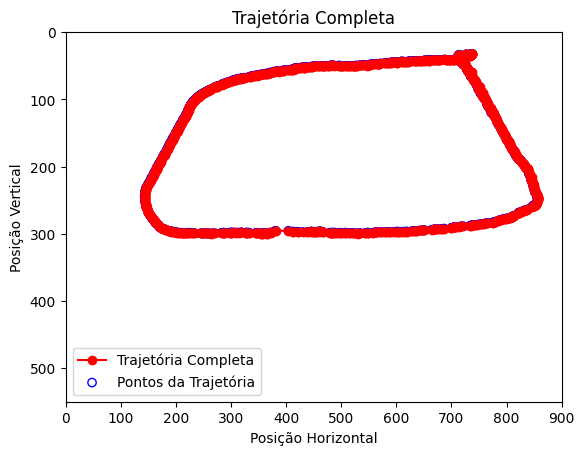

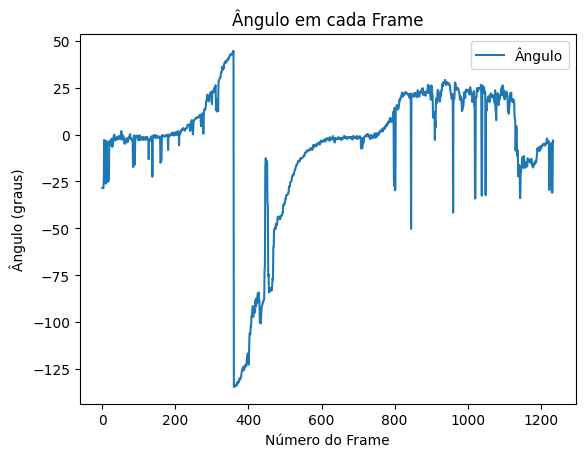

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio
import sys

plt.close('all')
print('Resultados Obtidos no Programa: ')

# Carregando o arquivo de vídeo
husky = cv2.VideoCapture("video2_husky.mp4") ###################ÍNDICE DO VIDEO QUE ESTÁ SENDO GERADO

# Definindo a quantidade de FPS do vídeo e intervalo entre os frames a serem amostrados:
fps = 20        # Quantidade de quadros a serem plotados em 1 único segundo ao final do programa
numframes = 50   # Taxa de Amostragem do video original (isso é, a cada quantos quadros eu carrego um frame)

# Redirecionar a saída padrão para um arquivo de texto
sys.stdout = open('husky2.2_informations.txt', 'w') ###################ÍNDICE DO VIDEO QUE ESTÁ SENDO GERADO

# Definindo S1 - matriz unitária de comparação para função morfológica
S1 = np.ones((3, 3), dtype=np.uint8)

# Lista para armazenar os ângulos em cada frame
angles = []

#Define uma função chamada plot_moments que recebe um frame, histórico de centróides, velocidades e índice do frame
def plot_moments(frame, centroid_history, velocities, frame_index):

    # Figura Nova e Eixos do Matplotlib para a plotagem dos resultados
    fig, ax = plt.subplots()

    # Mostrar o frame original convertido em um formato de cores RGB
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Convertendo o frame original para escala de cinza 
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Geramos aqui a cromaticidade do frame
    R = frame[:, :, 2]
    B = frame[:, :, 0]
    G = frame[:, :, 1]
    Y = R + B + G
    r = R / Y
    g = G / Y

    # Com r podemos aplicar o thresholding para demilitar a caixa
    # Limites para delimitar a parte vermelha do husky
    Frame_tresh = ((r >= 0.5) & (g <= 0.2)).astype(np.uint8) * 255

    # Removendo o ruído da imagem através de Operações Morfológicas (Dilatação e Erosão)
    Frame_noise = cv2.erode(cv2.dilate(Frame_tresh, S1), S1)

    # Gerando os blobs ("regiões conectadas") da imagem
    _, Frame_blobs = cv2.connectedComponents(Frame_noise)
    Frame_blobs = Frame_blobs > 0

    # Obtendo as propriedades dos blobs (área e pontos coordenados)
    m00 = np.sum(Frame_blobs)
    rows, cols = Frame_blobs.shape
    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    # Cálculo e Armazenamento das coordenadas do centróide na lista de histórico
    uc = np.sum(X * Frame_blobs) / m00
    vc = np.sum(Y * Frame_blobs) / m00
    centroid_history.append((uc, vc))  # Adiciona a posição atual à lista de histórico

    # Cálculo e impressão das informações do centróide no arquivo .TXT
    ax.scatter(uc, vc, c='none', edgecolors='b', marker='o', label='Centroide')
    print("\n------------------- Husky Information ----------------------")
    print('Centroide da Imagem:', [uc, vc])

    # Cálculo e impressão das informações sobre os Momentos Centrais e Matriz Inércia no arquivo .TXT
    u20 = np.sum((X - uc)**2 * Frame_blobs) / m00
    u02 = np.sum((Y - vc)**2 * Frame_blobs) / m00
    u11 = np.sum((X - uc) * (Y - vc) * Frame_blobs) / m00
    J = np.array([[u20, u11], [u11, u02]])
    print("Momentos Centrais e Matriz de Inércia:")
    print(J)

    # Calcula os autovalores e autovetores da matriz de inércia, determina o ângulo e armazena na lista de ângulos.
    lmbda, x = np.linalg.eig(J)
    global angles   #Cria uma variável de ângulo global para ser armazenada 
    i = np.argmax(lmbda)                              
    angles.append(np.rad2deg(np.arctan2(x[1, i], x[0, i])))     #Faz a detecção e armazenamento desses ângulos
 
    # Calcula a direção com base no autovetor correspondente ao maior autovalor e imprime a direção.
    i = np.argmax(lmbda)
    v = x[:, i]
    angle = np.rad2deg(np.arctan2(v[1], v[0]))
    print("Direção:", angle, '[graus]')
    print("------------------------------------------------------------")

    # Adiciona uma elipse na imagem para representar a inércia do objeto.
    ellipse = plt.matplotlib.patches.Ellipse((uc, vc), width=np.sqrt(lmbda[0] * 5.991), height=np.sqrt(lmbda[1] * 5.991),
                                             angle=angle, edgecolor='c', linewidth=2, fill=False, label='Inércia')
    ax.add_patch(ellipse)

    # Desenha a trajetória (rastro) do centróide
    if len(centroid_history) > 1:
        # Se houver mais de um ponto no histórico, plota a trajetória.
        centroid_history_np = np.array(centroid_history)
        ax.plot(centroid_history_np[:, 0], centroid_history_np[:, 1], 'ro-', label='Trajetória')

        # Adiciona seta indicadora de direção no último ponto da trajetória
        dx = centroid_history_np[-1, 0] - centroid_history_np[-2, 0]
        dy = centroid_history_np[-1, 1] - centroid_history_np[-2, 1]
        arrow_scale = 25  # Ajuste o valor conforme necessário

        # Ajuste o valor de head_length para controlar o comprimento do traço
        ax.arrow(
            centroid_history_np[-1, 0],
            centroid_history_np[-1, 1],
            dx,
            dy,
            head_width=arrow_scale,
            head_length=arrow_scale*1.5,  # Ajuste de valor para controlar o comprimento do traço
            fc='g',
            ec='g'
        )

        # Calcula e Adiciona velocidade instantânea ao gráfico
        speed = np.sqrt(dx**2 + dy**2)
        velocities.append(speed)
        ax.text(centroid_history_np[-1, 0] + 10, centroid_history_np[-1, 1] + 10, f'{speed:.2f} px/frame', color='g')

    ax.legend()
    plt.close(fig)  # Fechar a figura após obter os dados

    return fig

# Configuração do arquivo de vídeo de saída
video_writer = imageio.get_writer('husky2.2_original_with_ellipse_and_trace.mp4', fps=fps) ###################ÍNDICE DO VIDEO QUE ESTÁ SENDO GERADO

# Lista para armazenar o histórico de posições do centróide e velocidades
centroid_history = []
velocities = []

# Variáveis para calcular a distância total percorrida
total_distance = 0

# A cada frame do vídeo carregado, será realizada um conjunto de operações (Loop Principai)
i = 0
while husky.isOpened():
    ret, frame = husky.read()
    if not ret:
        husky.release()
        break

    # Configurar o intervalo de plotagem dos quadros do vídeo original
    numero_de_frames = numframes

    if i % numero_de_frames == 0:
        fig = plot_moments(frame, centroid_history, velocities, i)

        # Calcular a distância percorrida no último intervalo
        if len(centroid_history) > 1:
            delta_x = centroid_history[-1][0] - centroid_history[-2][0]
            delta_y = centroid_history[-1][1] - centroid_history[-2][1]
            distance = np.sqrt(delta_x**2 + delta_y**2)
            total_distance += distance

        # Salvar o frame com a elipse e a trajetória no arquivo de vídeo
        canvas = FigureCanvas(fig)
        canvas.draw()
        img = np.array(canvas.renderer.buffer_rgba())
        video_writer.append_data(img)

    i += 1

# Calcular a velocidade média
tempo_total = i / fps
velocidade_media = total_distance / tempo_total

# Exibir e salvar a velocidade média, tempo e distância total
print("\n-------------------- Husky Parameters -----------------------")
print(f"Taxa de Quadro do Video: {fps} frames por segundo")
print(f"Intervalo de Amostragem a cada: {numframes} frames")
print(f"Velocidade Média do Husky: {velocidade_media} pixels por segundo")
print(f"Distância Total Percorrida pelo Husky: {total_distance} pixels")
print(f"Tempo Total Percorrido pelo Husky: {tempo_total} segundo")
print("--------------------------------------------------------------")

husky.release()
video_writer.close()

# Restaurar a saída padrão após a execução do programa
sys.stdout = sys.__stdout__

### Plotagem do Gráfico da Trajetória Completa e Angulo realizada pelo Robô
# Plotar a trajetória completa após o loop do vídeo
trajectory_fig, trajectory_ax = plt.subplots()
centroid_history_np = np.array(centroid_history)

# Inverter o eixo Y e definir limites
trajectory_ax.set_xlim(0, 900)
trajectory_ax.set_ylim(0, 550)
trajectory_ax.invert_yaxis()

### Configurando a plotagem dos eixos, plotando e salvando o Gráfico da Trajetória do Husky
trajectory_ax.plot(centroid_history_np[:, 0], centroid_history_np[:, 1], 'ro-', label='Trajetória Completa')
trajectory_ax.scatter(centroid_history_np[:, 0], centroid_history_np[:, 1], c='none', edgecolors='b', marker='o', label='Pontos da Trajetória')
trajectory_ax.set_xlabel('Posição Horizontal')
trajectory_ax.set_ylabel('Posição Vertical')
trajectory_ax.legend()
plt.title('Trajetória Completa')
plt.savefig('Husky2.2_graphic_trajectory.png') ###################ÍNDICE DO VIDEO QUE ESTÁ SENDO GERADO
plt.show()

### Plotagem do Gráfico de Ângulos em cada Frame
angle_fig, angle_ax = plt.subplots()
angle_ax.plot(range(len(centroid_history)), angles, label='Ângulo')
angle_ax.set_xlabel('Número do Frame')
angle_ax.set_ylabel('Ângulo (graus)')
angle_ax.legend()
plt.title('Ângulo em cada Frame')
plt.savefig('Husky2.2_angle_graph.png') ###################ÍNDICE DO VIDEO QUE ESTÁ SENDO GERADO
plt.show()

plt.close('all')

